# Digital Signal and Image Processing Project - Image Retrieval

# Imports and Dataset

In [1]:
from google.colab import drive
import zipfile
import shutil
import os
import numpy as np
import random as python_random
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.neighbors import KDTree
from sklearn.metrics import accuracy_score, classification_report

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, Model
import random

np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)
keras.utils.set_random_seed(0)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset Import and Split

The dataset is imported, extracted and divided into train-val-test sets, with a proportion of 60-20-20.

The folder "dataset" is created which contains 3 sub folders for the 3 splits. The images are still divided by category.

Dictionaries are used to map label indices to their corresponding category names and vice versa.

### For Pre-Trained approach

In [ ]:
# Transfer dataset, and extract files
shutil.copy('/content/drive/My Drive/MammalsDataset.zip', 'MammalsDataset.zip')
zipf = zipfile.ZipFile('MammalsDataset.zip')
zipf.extractall()
zipf.close()

os.remove('MammalsDataset.zip') # Delete the copied zip file

In [ ]:
dataset_origin_path = "mammals"
dataset_path = "dataset"
train_ratio, val_ratio, test_ratio = 0.6, 0.2, 0.2

# Create destination directories
for split in ['train', 'val', 'test']:
    split_path = os.path.join(dataset_path, split)
    os.makedirs(split_path, exist_ok=True)

# Iterate through each category (sub-folder)
for category in os.listdir(dataset_origin_path):
    category_path = os.path.join(dataset_origin_path, category)

    images = os.listdir(category_path)
    python_random.shuffle(images)

    train_end = int(train_ratio * len(images))
    val_end = train_end + int(val_ratio * len(images))

    splits = {
        'train': images[:train_end],
        'val': images[train_end:val_end],
        'test': images[val_end:]
    }

    # Move images to respective directories
    for split, split_images in splits.items():
        split_category_path = os.path.join(dataset_path, split, category)
        os.makedirs(split_category_path, exist_ok=True)

        for img in split_images:
            shutil.move(os.path.join(category_path, img), os.path.join(split_category_path, img))

    # Remove empty category folder
    os.rmdir(category_path)

# Remove the original dataset folder if empty
if not os.listdir(dataset_origin_path):
    os.rmdir(dataset_origin_path)

print("Dataset split completed successfully.")


Dataset split completed successfully.


Dictionaries are created in order to map label indices to their corresponding category names and vice versa, whenever this will be needed later in the project.

In [ ]:
category_names = sorted([d for d in os.listdir(dataset_path + "/train") if os.path.isdir(os.path.join(dataset_path + "/train", d))])
category_to_index = {name: i for i, name in enumerate(category_names)}
index_to_category = {i: name for name, i in category_to_index.items()}

### For training siamese network aproach

In [2]:
# Transfer dataset, and extract files
shutil.copy('/content/drive/My Drive/mammals_reduced.zip', 'mammals_reduced.zip')
zipf = zipfile.ZipFile('mammals_reduced.zip')
zipf.extractall()
zipf.close()

os.remove('mammals_reduced.zip') # Delete the copied zip file

In [3]:
# Versione ridotta del dataset
dataset_origin_path_reduced = "mammals_reduced"
dataset_path_reduced = "dataset_reduced"

train_ratio, val_ratio, test_ratio = 0.6, 0.2, 0.2

# Crea le cartelle di destinazione per il dataset ridotto
for split in ['train', 'val', 'test']:
    split_path = os.path.join(dataset_path_reduced, split)
    os.makedirs(split_path, exist_ok=True)

# Itera su ogni categoria nel dataset ridotto
for category in os.listdir(dataset_origin_path_reduced):
    category_path = os.path.join(dataset_origin_path_reduced, category)

    # Controlla che sia una cartella (evita file strani)
    if not os.path.isdir(category_path):
        continue

    images = os.listdir(category_path)
    python_random.shuffle(images)

    train_end = int(train_ratio * len(images))
    val_end = train_end + int(val_ratio * len(images))

    splits = {
        'train': images[:train_end],
        'val': images[train_end:val_end],
        'test': images[val_end:]
    }

    # Sposta le immagini nelle rispettive directory
    for split, split_images in splits.items():
        split_category_path = os.path.join(dataset_path_reduced, split, category)
        os.makedirs(split_category_path, exist_ok=True)

        for img in split_images:
            shutil.move(os.path.join(category_path, img), os.path.join(split_category_path, img))

    # Rimuovi la cartella vuota
    os.rmdir(category_path)

print("Dataset split completed successfully.")


Dataset split completed successfully.


Dictionaries are created in order to map label indices to their corresponding category names and vice versa, whenever this will be needed later in the project.

In [4]:
category_names_reduced = sorted([d for d in os.listdir(dataset_path_reduced + "/train") if os.path.isdir(os.path.join(dataset_path_reduced + "/train", d))])
category_to_index_reduced = {name: i for i, name in enumerate(category_names_reduced)}
index_to_category_reduced = {i: name for name, i in category_to_index_reduced.items()}

# Pre-Trained CNN Approach
This section explores the base approach of extracting the feature arrays from a pre-trained network (MobileNetV2), and using a kd-tree to retrieve similar images quickly.

## Functions

In [8]:
def extract_features(model, root_folder, category_to_index, preprocess_function, image_size=(224, 224)):
    """
    Extract features from images in a root folder organized into subfolders by labels.
    Returns the features, the labels, and the corresponding image paths.
    """
    features = []
    labels = []
    image_paths = []

    for category in sorted(os.listdir(root_folder)):
        category_path = os.path.join(root_folder, category)
        print("Processing folder", category_path)

        if os.path.isdir(category_path):
            if category not in category_to_index:
                print(f"Skipping folder '{category}' as it is not in the category mapping.")
                continue

            label = category_to_index[category]  # Convert category name to label index

            image_files = [fname for fname in os.listdir(category_path) if fname.lower().endswith(('jpg', 'jpeg', 'png'))]

            for fname in image_files:
                image_path = os.path.join(category_path, fname)

                image = load_img(image_path, target_size=image_size)
                image_array = img_to_array(image)
                image_array = preprocess_function(image_array)
                image_array = np.expand_dims(image_array, axis=0)

                feature = model.predict(image_array, verbose=0)

                features.append(feature.flatten())
                labels.append(label)
                image_paths.append(image_path)

    return np.array(features), np.array(labels), image_paths

In [9]:
def load_or_compute_features(model, features_path, labels_path, paths_path, images_folder, category_to_index, preprocess_function=preprocess_input):
    """
    This function loads the saved features, labels and image paths (if available),
    otherwise it computes, saves them and returns them.
    """
    # Check if the feature, label, and image path files exist
    if os.path.exists(features_path):
        # Load the files if they exist
        train_features = np.load(features_path)
        train_labels = np.load(labels_path)
        train_image_paths = list(np.load(paths_path, allow_pickle=True))
        print("Loaded existing files.")
    else:
        # Otherwise, compute them
        print("Files missing, computing features...")
        train_features, train_labels, train_image_paths = extract_features(model, images_folder, category_to_index, preprocess_function)

        # Create the folder if it doesn't exist already
        features_save_folder = os.path.dirname(features_path)
        if not os.path.exists(features_save_folder):
            os.makedirs(features_save_folder)

        # Save the computed features, labels, and image paths
        np.save(features_path, train_features)
        np.save(labels_path, train_labels)
        np.save(paths_path, train_image_paths)
        print("Computed and saved new features.")

    return train_features, train_labels, train_image_paths

## Feature Extraction

Extraction of the features for every image in the train, val and test set. The numpy arrays are saved to disk to avoid re-computing them in later executions.

In [7]:
# Load of MobileNetV2 without the top layer
mobilenet = MobileNetV2(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))

KeyboardInterrupt: 

In [ ]:
dataset_train_path = dataset_path + "/train"
train_features_path = "/content/drive/My Drive/IR Saves/Pre-Trained Approach/train_features.npy"
train_labels_path = "/content/drive/My Drive/IR Saves/Pre-Trained Approach/train_labels.npy"
train_image_names_path = "/content/drive/My Drive/IR Saves/Pre-Trained Approach/train_image_names.npy"

train_features, train_labels, train_image_paths = load_or_compute_features(mobilenet, train_features_path, train_labels_path, train_image_names_path, dataset_train_path, category_to_index)

Loaded existing files.


In [ ]:
dataset_val_path = dataset_path + "/val"
val_features_path = "/content/drive/My Drive/IR Saves/Pre-Trained Approach/val_features.npy"
val_labels_path = "/content/drive/My Drive/IR Saves/Pre-Trained Approach/val_labels.npy"
val_image_names_path = "/content/drive/My Drive/IR Saves/Pre-Trained Approach/val_image_names.npy"

val_features, val_labels, val_image_paths = load_or_compute_features(mobilenet, val_features_path, val_labels_path, val_image_names_path, dataset_val_path, category_to_index)

Loaded existing files.


In [ ]:
dataset_test_path = dataset_path + "/test"
test_features_path = "/content/drive/My Drive/IR Saves/Pre-Trained Approach/test_features.npy"
test_labels_path = "/content/drive/My Drive/IR Saves/Pre-Trained Approach/test_labels.npy"
test_image_names_path = "/content/drive/My Drive/IR Saves/Pre-Trained Approach/test_image_names.npy"

test_features, test_labels, test_image_paths = load_or_compute_features(mobilenet, test_features_path, test_labels_path, test_image_names_path, dataset_test_path, category_to_index)

Loaded existing files.


This means that the train features are 1280 long arrays, for each of the 8234 images.

In [ ]:
train_features.shape

(8234, 1280)

## Image Retrieval
This section creates the kd-tree, evaluates it and explores the results.

### Functions

In [53]:
def print_retrieved_images(train_image_paths, test_image_paths, test_image_indices, query_indexes, query_distances):
    """
    Plots the query image and its k nearest neighbors for each test image.
    """
    # Number of test images to plot
    num_test_images = len(test_image_indices)

    # Number of nearest neighbors to display
    k = len(query_indexes[0])

    # Adjust the figsize dynamically based on the number of images to display horizontally
    fig_width = 3 * (k + 1)  # 1 for the query image and k for neighbors
    fig_height = 3 * num_test_images  # 3 units of height per image row

    # Set up the plot with multiple rows (one for each test image) and (k + 1) columns (1 for the query image and k for neighbors)
    fig, axes = plt.subplots(num_test_images, k + 1, figsize=(fig_width, fig_height))

    # Loop over each test image index
    for i, test_image_index in enumerate(test_image_indices):
        # Get the test image
        test_image_path = test_image_paths[test_image_index]
        test_image = load_img(test_image_path)

        # Extract category (folder name) and image name for the test image
        test_image_category = os.path.basename(os.path.dirname(test_image_path))
        test_image_name = os.path.basename(test_image_path)

        # Plot the test image (query)
        axes[i, 0].imshow(test_image)
        axes[i, 0].set_title(f"Query:\n {test_image_name}")
        axes[i, 0].axis('off')  # Hide axes for the image

        # Plot the k nearest images
        for j, (index, dist) in enumerate(zip(query_indexes[i], query_distances[i])):
            # Load the neighbor image
            neighbor_image_path = train_image_paths[index]
            neighbor_image = load_img(neighbor_image_path)

            # Extract the category (folder name) and name for the neighbor image
            neighbor_category = os.path.basename(os.path.dirname(neighbor_image_path))
            neighbor_name = os.path.basename(neighbor_image_path)

            # Plot the neighbor image
            axes[i, j + 1].imshow(neighbor_image)
            axes[i, j + 1].set_title(f"{neighbor_name}\n(Dist: {dist:.2f})")
            axes[i, j + 1].axis('off')  # Hide axes for the image

    plt.tight_layout()
    plt.show()


In [54]:
def evaluate_performance(query_indexes, test_labels, train_labels, index_to_category, k=3):
    """
    Evaluate the performance of the using the provided indices.
    For each test image, check each of the k nearest neighbors individually.
    """
    # List to store predictions and true labels for classification report
    predicted_labels = []
    true_labels = []

    # Loop over each test image
    for i, query_index in enumerate(query_indexes):
        # Get the true label for the test image
        true_label = test_labels[i]

        # Get the labels of the k nearest neighbors
        neighbor_labels = train_labels[query_index]

        # Check each neighbor individually and append to predictions
        for neighbor_label in neighbor_labels:
            predicted_labels.append(neighbor_label)  # Store the predicted neighbor label
            true_labels.append(true_label)           # Store the true label for the test sample

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Generate the classification report
    print("\nClassification Report:")

    # Convert numeric labels to category names using index_to_category
    category_names = [index_to_category[label] for label in np.unique(train_labels)]

    # Print the classification report with category names
    print(classification_report(true_labels, predicted_labels, target_names=category_names))

    # Generate classification report as a dictionary for easier extraction of metrics
    report = classification_report(true_labels, predicted_labels, target_names=category_names, output_dict=True)

    # Extract precision, recall, and f1-score for each class
    class_report = []
    for class_name, metrics in report.items():
        if class_name not in ['accuracy', 'macro avg', 'weighted avg']:  # Ignore overall averages
            class_report.append({
                'Class': class_name,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score']
            })

    # Convert the class report to a DataFrame
    report_df = pd.DataFrame(class_report)

    return report_df


In [55]:
def calculate_anmrr(query_indexes, test_labels, train_labels, k=3):
    """
    Calculate Average Normalized Modified Retrieval Rank (ANMRR)s.
    """
    tests_number = len(query_indexes)  # Number of queries
    total_score = 0

    for i, query_index in enumerate(query_indexes):
        true_label = test_labels[i]  # True label of the current query

        # Get the labels of the k nearest neighbors
        neighbor_labels = train_labels[query_index]

        # Compute AVR(q) - the average rank of relevant documents
        relevant_ranks = []
        for rank, neighbor_label in enumerate(neighbor_labels):
            if neighbor_label == true_label:
                relevant_ranks.append(rank + 1)  # Add 1 to convert from 0-indexed to 1-indexed rank

        if relevant_ranks:
            average_rank_relevant_documents = np.mean(relevant_ranks)  # Average rank of relevant documents
        else:
            average_rank_relevant_documents = k + 1  # If no relevant documents found, set to K + 1

        # Calculate the ANMRR for the query
        number_relevant_documents = 1
        denominator = 1.25 * k - 0.5 * (1 + number_relevant_documents)
        if denominator == 0:  # Handle case when the denominator becomes zero
            continue  # Skip this query, as division by zero is not valid

        score = (average_rank_relevant_documents - 0.5 * (1 + number_relevant_documents)) / denominator
        total_score += score

    # Return the final ANMRR score
    ANMRR = total_score / tests_number
    return ANMRR

In [56]:
def retrieve_and_evaluate_category(kd_tree, category_name, num_images, root_test_folder, category_to_index):
    """
    Retrieves and evaluates images for a specific category using a KD-Tree.
    """

    print(f"Retrieving images for category {category_name}...")

    # Get the category index from the category name using the category_to_index mapping
    if category_name not in category_to_index:
        raise ValueError(f"Category '{category_name}' not found in the category_to_index mapping.")

    category_index = category_to_index[category_name]

    # Find indices of test images belonging to the specified category
    test_image_indices = [i for i, label in enumerate(test_labels) if label == category_index]

    # Limit the number of images to num_images (if available)
    test_image_indices = test_image_indices[:min(num_images, len(test_image_indices))]

    # Extract features for the selected test images
    test_images = test_features[test_image_indices]

    # Perform k-NN search using the KD-Tree
    k = 3  # Number of neighbors to retrieve
    query_distances, query_indexes = kd_tree.query(test_images, k=k)

    # Print retrieved images
    print_retrieved_images(train_image_paths, test_image_paths, test_image_indices, query_indexes, query_distances)

    # Calculate and print ANMRR
    anmrr_value = calculate_anmrr(query_indexes, test_labels[test_image_indices], train_labels, k=k)
    print(f"ANMRR for category {category_name}: {anmrr_value:.4f}")

### KD-Tree

The kd-tree is created on the train fetures that were extracted earlier.

In [ ]:
kd_tree = KDTree(train_features)

#### Testing on a few images

Testing the kd-tree and its returned data on 3 random images.

In [ ]:
len(test_features)

2786

The images are picked with 3 random indices, and their respective feature arrays are retrieved.

In [ ]:
test_image_indices = [0, 1000, 2000]
test_images = test_features[test_image_indices]
test_images.shape

(3, 1280)

5 images are retrieved for each one of the 3 test images.

In [ ]:
distances, indices = kd_tree.query(test_images, k=5)

In [ ]:
distances

array([[11.66054006, 12.2628642 , 12.34946761, 12.62637917, 12.92708526],
       [24.20629408, 24.51491907, 24.56012745, 24.74629475, 24.77928495],
       [10.88933873, 11.49297876, 12.10918684, 12.15804577, 12.23076107]])

In [ ]:
indices

array([[  78,  139,   52,   11,   56],
       [ 753, 4415, 4296, 4389, 8022],
       [5888, 6030, 5996, 5860, 5919]])

This function takes the result of the kd-tree query and displays dynamically the original image and all of the retrieved images, with useful informations displayed in the titles.

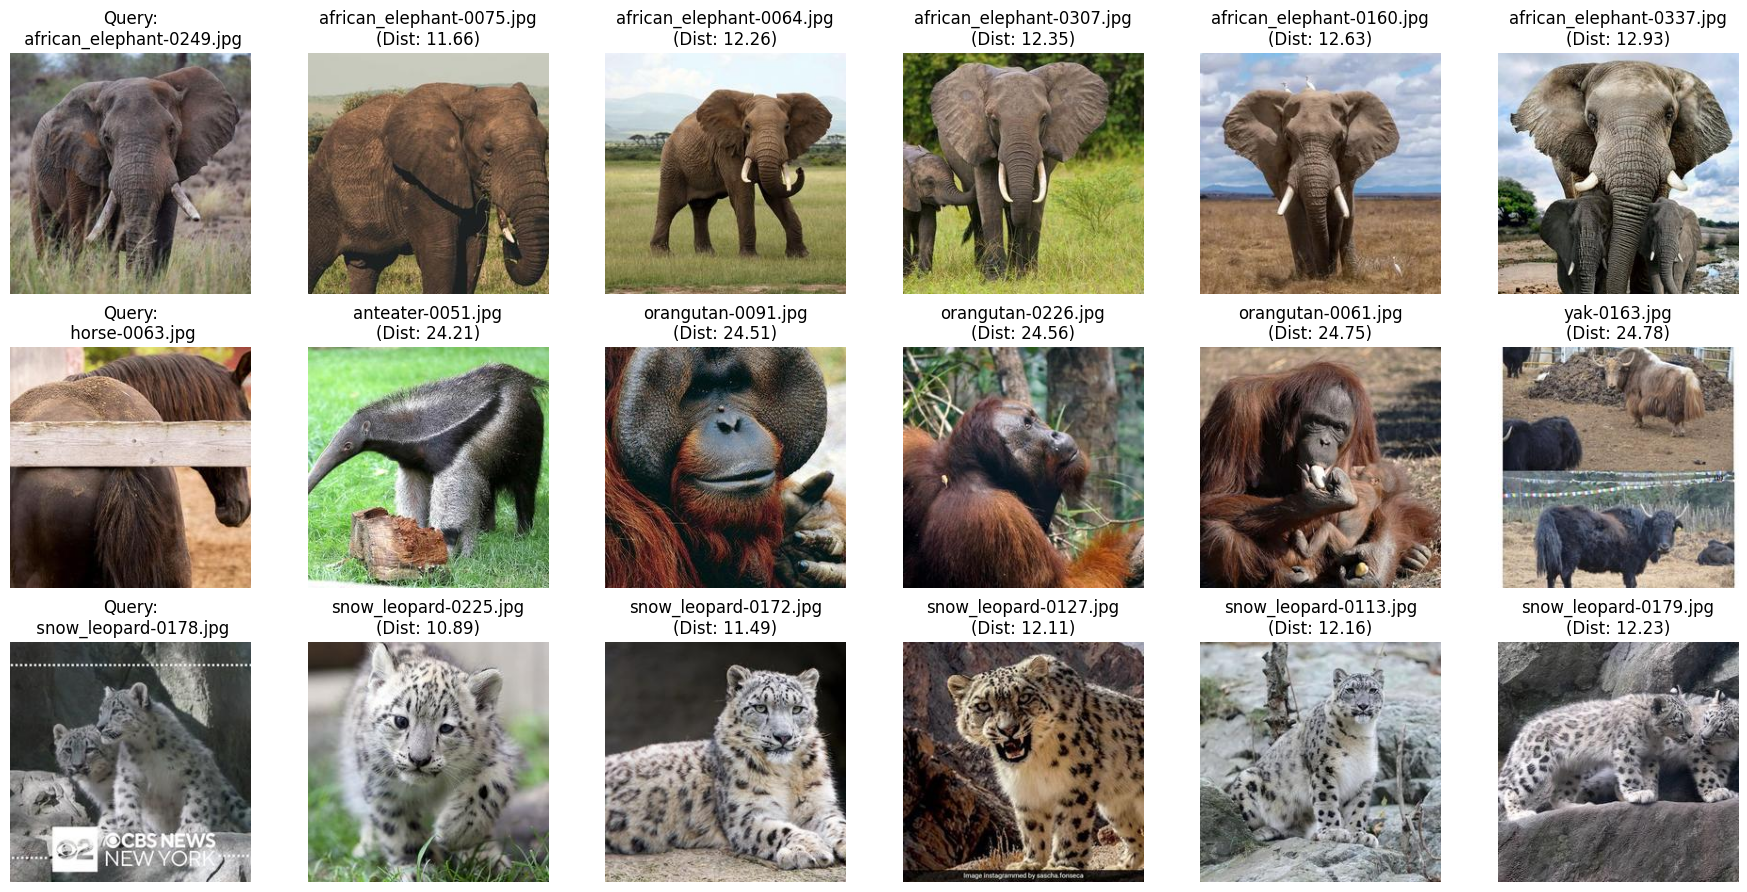

In [ ]:
print_retrieved_images(train_image_paths, test_image_paths, test_image_indices, indices, distances)

#### Evaluation
The method is then more thoroughly evaluated by retrieving 3 images for each test image.

In [ ]:
k = 3
query_distances, query_indexes = kd_tree.query(test_features, k=k)

KeyboardInterrupt: 

This function takes the result of the kd-tree query, calculates and displays the accuracy and the classification report.

In [ ]:
performance_df = evaluate_performance(query_indexes, test_labels, train_labels, index_to_category, k)

Since the classification report isn't much readable due to the large number of classes, the function also returns a dataframe which can be easily navigated.

In [ ]:
performance_df.sort_values(by='F1-Score', ascending=False)[:10]

Analyzing the classes which are harded to retrieve correctly will give us insights on what this method is struggling with.

In [ ]:
performance_df.sort_values(by='F1-Score', ascending=True)[:10]

The ANMRR (Average Normalized Modified Retrieval Rank) score is a measure of retrieval effectiveness. It ranges between 0 and 1 where 0 indicates perfect retrieval, meaning that all relevant items are ranked at the top, and 1 indicates worst-case retrieval, meaning relevant items are ranked very poorly or not retrieved at all. The "rank" is the position of the correctly retrieved images in the returned array, where the top of the ranking is occupied by the image with lowest distance to the query image.

A ANMRR score of 0.3914 is not bad.

In [ ]:
anmrr_value = calculate_anmrr(query_indexes, test_labels, train_labels, k=3)
print(f"ANMRR: {anmrr_value:.4f}")

This function is used to explore a single category by testing on a given number of images, displaying the results and calculating the class-specific ANMRR score.

The issue with this class is clearly due to the high similarity with other categories like "highland_cattle" and "american_bison".

Some of these images could also be mistakes of the dataset itself, but since we are not experts of wild life, it's hard to tell.

In [ ]:
retrieve_and_evaluate_category(kd_tree, "yak", 5, dataset_test_path, category_to_index)

# Siamese Network Approach

In order to make a siamese network with triplet loss we'll need the following pieces:
- Encoder model: A single neural network used to transform each image into a feature vector (embedding).
- Triples loss function that evaluates loss on:
  - Anchor (the reference image)
  - Positive (an image of the same class as the Anchor)
  - Negative (an image from a different class)

---------

In [ ]:
def plot_triplet(triplet):
    plt.figure(figsize=(6,2))
    for i in range(0,3):
        plt.subplot(1,3,i+1)
        plt.imshow(np.reshape(triplet[i], (224,224)), cmap='binary')
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [ ]:
def create_batch(batch_size):
    anchors = np.zeros((batch_size, 50176))
    positives = np.zeros((batch_size, 50176))
    negatives = np.zeros((batch_size, 50176))
    
    for i in range(0, batch_size):
        index = random.randint(0, 60000-1)
        anc = train_dataset_reduced[index]
        y = y_train[index]
        
        indices_pos = np.squeeze(np.where(y_train == y))
        indices_neg = np.squeeze(np.where(y_train != y))
        
        pos = x_train[indices_pos[random.randint(0, len(indices_pos)-1)]]
        neg = x_train[indices_neg[random.randint(0, len(indices_neg)-1)]]
        
        anchors[i] = anc
        positives[i] = pos
        negatives[i] = neg
        
    return [anchors, positives, negatives]

In [ ]:
triplet = create_batch(1)
plot_triplet(triplet)

## Setup functions

### Triplet Loss function

The triplet loss forces (Anchor - Positive) to come closer and (Anchor - Negative) to move away.

In [ ]:
def triplet_loss(margin=0.05):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, 0, :], y_pred[:, 1, :], y_pred[:, 2, :]
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        loss = tf.maximum(pos_dist - neg_dist + margin, 0.0)
        return tf.reduce_mean(loss)

    return loss

### Encoder network

This is pretty much the center of the whole siamese architecture, it will take in input 3 images and evaluate loss using custom loss fuction previosly designed

In [ ]:
def build_custom_encoder():
    """
    Costruisce un encoder CNN da zero per l'estrazione di feature.
    """
    inputs = layers.Input(shape=(224, 224, 3))

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.BatchNormalization()(x, training=True)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    #x = layers.BatchNormalization()(x, training=True)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    #x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)  # Embedding di 128 dimensioni
    x = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)  # Normalizzazione L2

    return Model(inputs, x, name="custom_encoder")


In [ ]:
def build_imagenet_encoder():
    base_cnn = keras.applications.ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_cnn.trainable = False  # Usa il modello pre-addestrato senza aggiornare i pesi inizialmente
    
    flatten = layers.GlobalAveragePooling2D()(base_cnn.output)
    dense = layers.Dense(128, activation="relu")(flatten)  # 128-D embedding
    norm = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dense)  # Normalizzazione L2

    return Model(base_cnn.input, norm, name="siamese_encoder")

### Triplet generator

We need to create a function to sample (Anchor, Positive, Negative). This will later be used by our encoder function to process 3 images at a time. We can do this by loading the dataset and selecting the images by class.

In [ ]:
IMG_SIZE = (224, 224)
batch_size = 4

In [ ]:
# Load image
def load_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Ensure 3 channels
    image = tf.image.resize(image, IMG_SIZE)  # Ensure correct size
    #image = image / 255.0  # Normalize
    return image

In [ ]:
def load_triplet(dataset_path, split='train'):
    """
    Load one sample, wich will be composed of a (Anchor, Positive, Negative) images combination
    """
    class_names = list(category_to_index_reduced.keys())

    # chose a random class
    pos_class = np.random.choice(class_names)
    pos_class_path = os.path.join(dataset_path, split, pos_class)

    # choose 2 images from same class
    pos_images = os.listdir(pos_class_path)
    if len(pos_images) < 2:
        # Recursion for classes with <2 images 
        return load_triplet(category_to_index_reduced, dataset_path, split)

    anchor_img, positive_img = np.random.choice(pos_images, 2, replace=False)

    # choose a different random class
    neg_class = np.random.choice([c for c in class_names if c != pos_class])
    neg_class_path = os.path.join(dataset_path, split, neg_class)
    negative_img = np.random.choice(os.listdir(neg_class_path))

    anchor = load_image(os.path.join(pos_class_path, anchor_img))
    positive = load_image(os.path.join(pos_class_path, positive_img))
    negative = load_image(os.path.join(neg_class_path, negative_img))

    return anchor, positive, negative

Next we need a custom data generator to give the model 3 images to process at once:

In [ ]:
def triplet_generator(batch_size, dataset_path, split):
    while True:
        anchors, positives, negatives = [], [], []

        for _ in range(batch_size):
            anchor, positive, negative = load_triplet(dataset_path, split)  # Carica le immagini

            anchors.append(anchor)
            positives.append(positive)
            negatives.append(negative)

        # Convertiamo in tensori e restituiamo separatamente
        yield (np.array(anchors), np.array(positives), np.array(negatives)), np.zeros((batch_size,))

This is a simple function that will keep gettting one sample afeter the other when it's called. thus inizializating it is pretty simple but will cause some overhead while running the training

### Prepare custom dataset

In [ ]:
def create_triplet_dataset(batch_size, dataset_path, split):
    def gen():
        while True:
            yield next(triplet_generator(batch_size, dataset_path, split))

    output_signature = (
        (tf.TensorSpec(shape=(batch_size, 224, 224, 3), dtype=tf.float32),  # Anchor
         tf.TensorSpec(shape=(batch_size, 224, 224, 3), dtype=tf.float32),  # Positive
         tf.TensorSpec(shape=(batch_size, 224, 224, 3), dtype=tf.float32)),  # Negative
        tf.TensorSpec(shape=(batch_size,), dtype=tf.float32)  # Dummy label
    )

    return tf.data.Dataset.from_generator(gen, output_signature=output_signature)

In [ ]:
def get_triplet_file_path(split):
    return f"{split}_triplets.npz"

def count_images_in_split(dataset_path, split):
    """Counts the total number of images in a dataset split."""
    split_path = os.path.join(dataset_path, split)
    total_images = sum(len(os.listdir(os.path.join(split_path, category))) 
                       for category in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, category)))
    return total_images

def preload_triplets_if_needed(dataset_path, split):
    """Checks if the triplet dataset is already stored in memory, if not, it creates and saves it."""
    file_path = get_triplet_file_path(split)
    
    if os.path.exists(file_path):
        print(f"Found existing {file_path}, skipping preprocessing.")
    else:
        num_samples = count_images_in_split(dataset_path, split)
        print(f"{file_path} not found, generating {num_samples} triplets...")
        
        anchors, positives, negatives = [], [], []
        
        for _ in range(num_samples):
            anchor, positive, negative = load_triplet(dataset_path, split)
            anchors.append(anchor)
            positives.append(positive)
            negatives.append(negative)
        
        np.savez(file_path, anchors=np.array(anchors), positives=np.array(positives), negatives=np.array(negatives))
        print(f"Saved {num_samples} triplets to {file_path}")

def load_precomputed_triplets(split, batch_size):
    """Loads precomputed triplets into a TensorFlow dataset."""
    file_path = get_triplet_file_path(split)
    data = np.load(file_path)
    
    anchors, positives, negatives = data["anchors"], data["positives"], data["negatives"]
    
    dataset = tf.data.Dataset.from_tensor_slices(((anchors, positives, negatives), np.zeros(len(anchors))))
    dataset = dataset.shuffle(buffer_size=252).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset


Next we create dataset using previous function and we test evrything so far is coded correctly by printing some shapes and images

Anchor shape: (4, 224, 224, 3)
Positive shape: (4, 224, 224, 3)
Negative shape: (4, 224, 224, 3)
Labels shape: (4,)


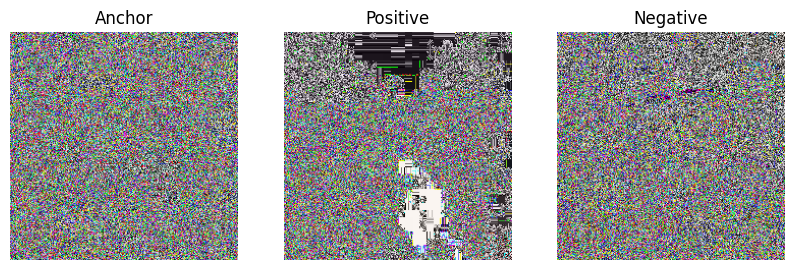

In [ ]:
train_dataset_reduced = (create_triplet_dataset(batch_size=batch_size, dataset_path=dataset_path_reduced, split="train"))
#                        .shuffle(buffer_size=252))  # Shuffling with a buffer

validation_dataset_reduced = create_triplet_dataset(batch_size=batch_size, dataset_path=dataset_path_reduced, split="val")
#test_dataset_reduced = create_triplet_dataset(batch_size=batch_size, dataset_path=dataset_path_reduced, split="test")

# Check and generate triplets if needed
#preload_triplets_if_needed(dataset_path_reduced, "train")
#preload_triplets_if_needed(dataset_path_reduced, "val")

# Load datasets
#train_dataset_reduced = load_precomputed_triplets("train", batch_size)
#validation_dataset_reduced = load_precomputed_triplets("val", batch_size)

# Fetch one batch from the dataset
for batch in train_dataset_reduced.take(1):
    (anchors, positives, negatives), labels = batch

    print("Anchor shape:", anchors.shape)
    print("Positive shape:", positives.shape)
    print("Negative shape:", negatives.shape)
    print("Labels shape:", labels.shape)


# Fetch one batch and display a sample
for batch in train_dataset_reduced.take(1):
    (anchors, positives, negatives), labels = batch
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].imshow((anchors[0].numpy() * 255).astype("uint8"))
    axes[0].set_title("Anchor")
    axes[1].imshow((positives[0].numpy() * 255).astype("uint8"))
    axes[1].set_title("Positive")
    axes[2].imshow((negatives[0].numpy() * 255).astype("uint8"))
    axes[2].set_title("Negative")
    for ax in axes:
        ax.axis("off")
    plt.show()
    break

Evrything should be working correctly as the graph showing triplet seems correct and each shape is the right dimension

### Siamese network definition

In [ ]:
def build_siamese_model(encoder):
    """
    Costruisce il modello Siamese che prende in input triplette.
    """
    anchor_input = layers.Input(shape=(224, 224, 3), name="anchor")
    positive_input = layers.Input(shape=(224, 224, 3), name="positive")
    negative_input = layers.Input(shape=(224, 224, 3), name="negative")

    anchor_emb = encoder(anchor_input)
    positive_emb = encoder(positive_input)
    negative_emb = encoder(negative_input)

    embeddings = layers.Lambda(lambda x: tf.stack(x, axis=1))([anchor_emb, positive_emb, negative_emb])

    return Model(inputs=[anchor_input, positive_input, negative_input], outputs=embeddings, name="siamese_network")


## Train network

In [ ]:
# Build new encoder model
encoder = build_imagenet_encoder()
#encoder.summary()

In [ ]:
# Creiamo la rete Siamese con il nuovo encoder
siamese_model = build_siamese_model(encoder)
siamese_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001), loss=triplet_loss())

siamese_model.summary()

Model: "siamese_network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ anchor (InputLayer) │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positive            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ siamese_encoder     │ (None, 128)       │ 23,849,984 │ anchor[0][0],     │
│ (Functional)        │                   │            │ positive[0][0],   │
│                     │                   │            │ negative[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 3, 128)    │          0 │ siamese_encoder[… │
│                     │                   │            │ siamese_encoder[… │
│                     │                   │            │ siamese_encoder[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,849,984 (90.98 MB)

 Trainable params: 262,272 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 0.0129 - val_loss: 0.0078
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.0117 - val_loss: 0.0180
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.0167 - val_loss: 0.0194
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.0076 - val_loss: 0.0142
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.0140 - val_loss: 0.0127
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 0.0272 - val_loss: 0.0112
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 0.0093 - val_loss: 0.0172
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 0.0204 - val_loss: 0.0125
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 0.0142 - val_loss: 0.0083
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.0129 - val_loss: 0.0151


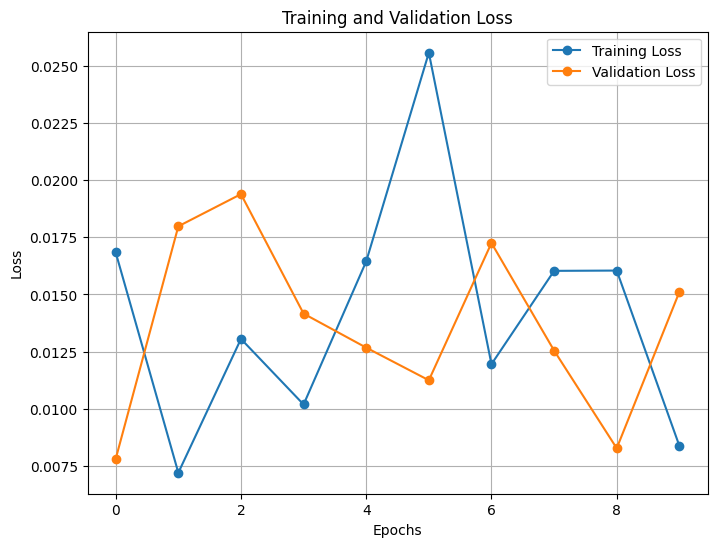

In [ ]:
history = siamese_model.fit(train_dataset_reduced, 
                  epochs=10, 
                  steps_per_epoch=10,
                  validation_steps = 10,
                  validation_data=validation_dataset_reduced
                  )


plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


## Results analisis

In [ ]:
siamese_model.save("siamese_model.h5")
encoder.save("encoder_model.h5")

In [ ]:
dataset_train_path = dataset_path_reduced + "/train"
prefix = "" #/content/drive/My Drive/
train_features_path = prefix+"IR Saves/SiameseNetwork Approach/train_features.npy"
train_labels_path = prefix+"IR Saves/SiameseNetwork Approach/train_labels.npy"
train_image_names_path = prefix+"IR Saves/SiameseNetwork Approach/train_image_names.npy"

train_features, train_labels, train_image_paths = load_or_compute_features(encoder, train_features_path, train_labels_path, train_image_names_path, dataset_train_path, category_to_index_reduced)

Loaded existing files.


In [ ]:
dataset_val_path = dataset_path_reduced + "/val"
val_features_path = prefix+"IR Saves/SiameseNetwork Approach/val_features.npy"
val_labels_path = prefix+"IR Saves/SiameseNetwork Approach/val_labels.npy"
val_image_names_path = prefix+"IR Saves/SiameseNetwork Approach/val_image_names.npy"

val_features, val_labels, val_image_paths = load_or_compute_features(encoder, val_features_path, val_labels_path, val_image_names_path, dataset_val_path, category_to_index_reduced)

Loaded existing files.


In [ ]:
dataset_test_path = dataset_path_reduced + "/test"
test_features_path = prefix+"IR Saves/SiameseNetwork Approach/test_features.npy"
test_labels_path = prefix+"IR Saves/SiameseNetwork Approach/test_labels.npy"
test_image_names_path = prefix+"IR Saves/SiameseNetwork Approach/test_image_names.npy"

test_features, test_labels, test_image_paths = load_or_compute_features(encoder, test_features_path, test_labels_path, test_image_names_path, dataset_test_path, category_to_index_reduced)

Loaded existing files.


#### kd-tree

The kd-tree is created on the train fetures that were extracted earlier.

In [ ]:
kd_tree = KDTree(train_features)

#### Testing on a few images

Testing the kd-tree and its returned data on 3 random images.

In [ ]:
len(test_features)

305

The images are picked with 3 random indices, and their respective feature arrays are retrieved.

In [ ]:
test_image_indices = [0, 30, 60]
test_images = test_features[test_image_indices]
test_images.shape

(3, 128)

5 images are retrieved for each one of the 3 test images.

In [ ]:
distances, indices = kd_tree.query(test_images, k=5)

In [ ]:
distances

array([[0.06286446, 0.06526682, 0.06844829, 0.07147348, 0.07308659],
       [0.05155102, 0.06302044, 0.06823106, 0.07073455, 0.07838498],
       [0.0517229 , 0.0545069 , 0.06374134, 0.06438113, 0.0646135 ]])

In [ ]:
indices

array([[378, 373,  54, 217, 649],
       [446, 112, 106, 574, 282],
       [325, 599, 139, 328, 303]])

This function takes the result of the kd-tree query and displays dynamically the original image and all of the retrieved images, with useful informations displayed in the titles.

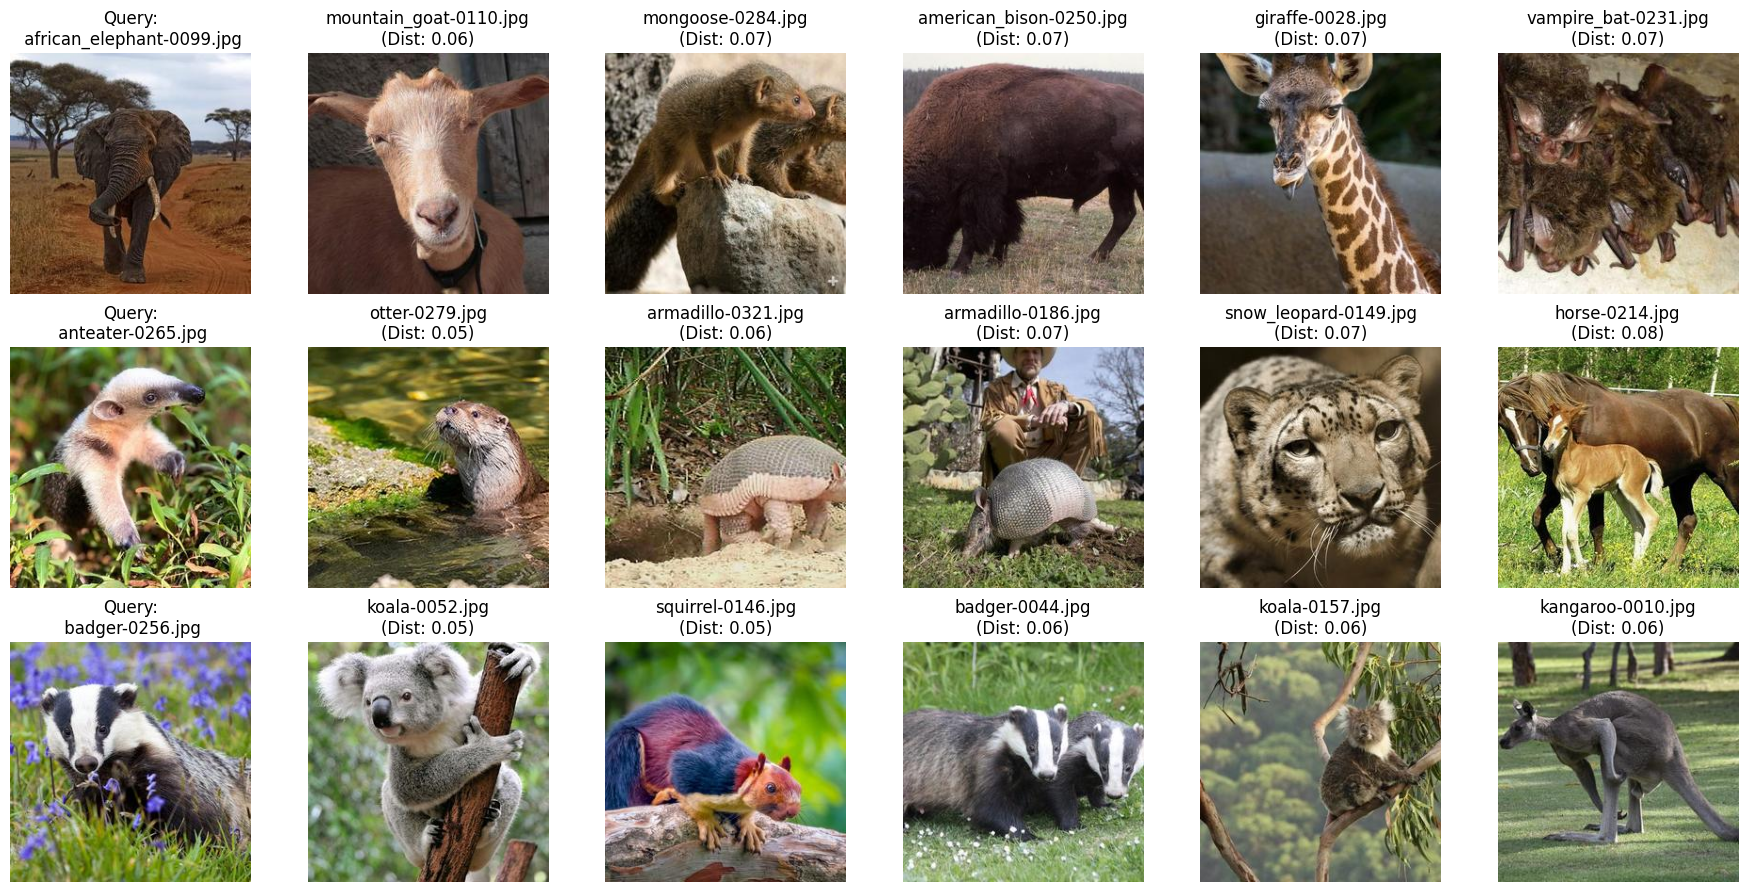

In [ ]:
print_retrieved_images(train_image_paths, test_image_paths, test_image_indices, indices, distances)

#### Evaluation
The method is then more thoroughly evaluated by retrieving 3 images for each test image.

In [ ]:
k = 3
query_distances, query_indexes = kd_tree.query(test_features, k=k)

This function takes the result of the kd-tree query, calculates and displays the accuracy and the classification report.

In [ ]:
performance_df = evaluate_performance(query_indexes, test_labels, train_labels, index_to_category_reduced, k)

Accuracy: 6.78%

Classification Report:
                  precision    recall  f1-score   support

african_elephant       0.00      0.00      0.00        24
          alpaca       0.04      0.04      0.04        24
  american_bison       0.05      0.04      0.04        24
        anteater       0.04      0.05      0.04        21
      arctic_fox       0.22      0.29      0.25        21
       armadillo       0.06      0.08      0.07        24
          baboon       0.00      0.00      0.00        24
          badger       0.04      0.05      0.05        21
      blue_whale       0.43      0.56      0.49        18
      brown_bear       0.05      0.06      0.05        18
           camel       0.10      0.07      0.08        15
         dolphin       0.07      0.05      0.06        21
         giraffe       0.09      0.06      0.07        18
       groundhog       0.10      0.11      0.11        18
 highland_cattle       0.00      0.00      0.00        21
           horse       0.08    

Since the classification report isn't much readable due to the large number of classes, the function also returns a dataframe which can be easily navigated.

In [ ]:
performance_df.sort_values(by='F1-Score', ascending=False)[:10]

Class  Precision    Recall  F1-Score
8     blue_whale   0.434783  0.555556  0.487805
4     arctic_fox   0.222222  0.285714  0.250000
19       manatee   0.181818  0.166667  0.173913
43           yak   0.153846  0.133333  0.142857
35   vampire_bat   0.142857  0.111111  0.125000
25    polar_bear   0.111111  0.142857  0.125000
33  sugar_glider   0.117647  0.133333  0.125000
27     red_panda   0.088235  0.142857  0.109091
13     groundhog   0.100000  0.111111  0.105263
20      mongoose   0.105263  0.095238  0.100000

Analyzing the classes which are harded to retrieve correctly will give us insights on what this method is struggling with.

In [ ]:
performance_df.sort_values(by='F1-Score', ascending=True)[:10]

Class  Precision  Recall  F1-Score
0   african_elephant        0.0     0.0       0.0
6             baboon        0.0     0.0       0.0
14   highland_cattle        0.0     0.0       0.0
16            jackal        0.0     0.0       0.0
21     mountain_goat        0.0     0.0       0.0
23         orangutan        0.0     0.0       0.0
38           warthog        0.0     0.0       0.0
34             tapir        0.0     0.0       0.0
41        wildebeest        0.0     0.0       0.0
42            wombat        0.0     0.0       0.0

The ANMRR (Average Normalized Modified Retrieval Rank) score is a measure of retrieval effectiveness. It ranges between 0 and 1 where 0 indicates perfect retrieval, meaning that all relevant items are ranked at the top, and 1 indicates worst-case retrieval, meaning relevant items are ranked very poorly or not retrieved at all. The "rank" is the position of the correctly retrieved images in the returned array, where the top of the ranking is occupied by the image with lowest distance to the query image.

A ANMRR score of 0.3914 is not bad.

In [ ]:
anmrr_value = calculate_anmrr(query_indexes, test_labels, train_labels, k=3)
print(f"ANMRR: {anmrr_value:.4f}")

ANMRR: 0.9687


This function is used to explore a single category by testing on a given number of images, displaying the results and calculating the class-specific ANMRR score.

The issue with this class is clearly due to the high similarity with other categories like "highland_cattle" and "american_bison".

Some of these images could also be mistakes of the dataset itself, but since we are not experts of wild life, it's hard to tell.

Retrieving images for category groundhog...


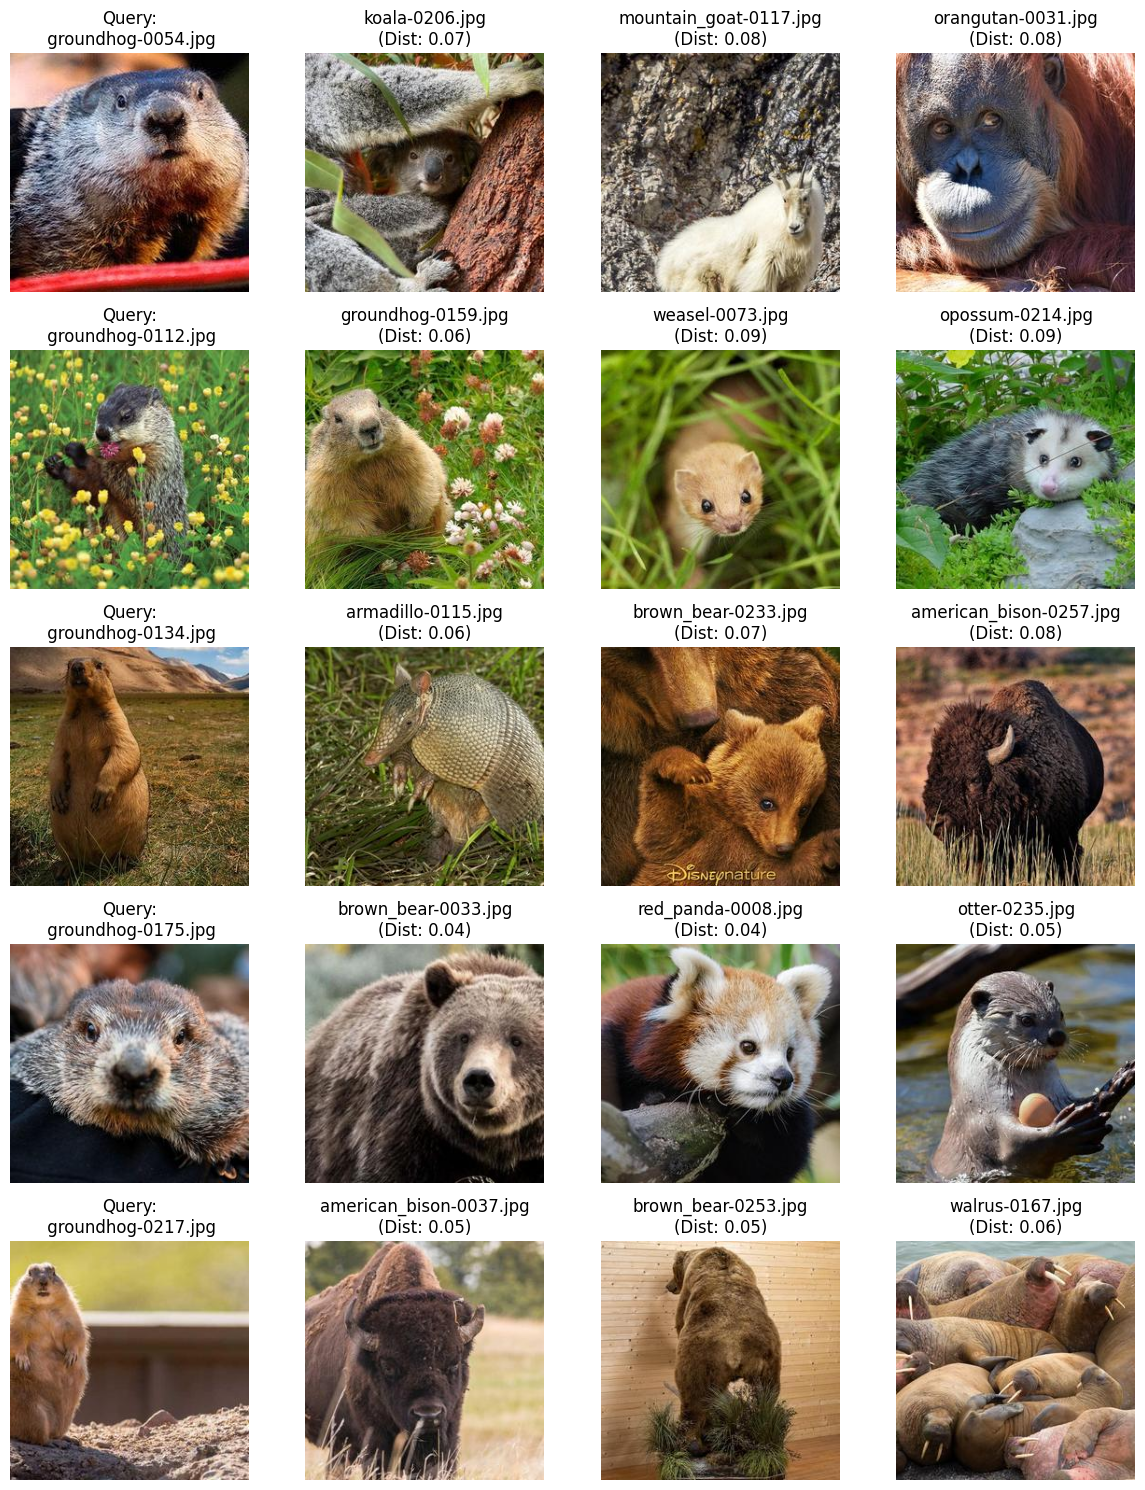

ANMRR for category groundhog: 0.8727


In [ ]:
retrieve_and_evaluate_category(kd_tree, "groundhog", 5, dataset_test_path, category_to_index_reduced)